# Preprocess and encode all collected hooks

## Setup

In [ ]:
# First mount your Google drive
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/Thesis/' # change this if needed

# Imports
import os
import numpy as np
import pickle as pkl

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load, examine, and vet the database

### Load pickle file

In [ ]:
ht_path = os.path.join(root_path, 'ht.pkl')
opened_file = open(ht_path, 'rb')
ht = pkl.load(opened_file)
opened_file.close()

print(f"Loaded HT database. Number of hooks: {len(ht)}")

Loaded HT database. Number of hooks: 4338


### Print keys for each hook object

In [ ]:
for key in dict.keys(ht[0]):
    print(key)

version
chords
notes
keys
tempos
meters
breaks
bands
lyrics
sections
cursor
settings
loopGui
youtube
keyFrames
activeMelodyIndex
endBeat
inactiveNotes
visibleMelodies
soloAndMutedMelodies
FXBypass
customFXParams
customSynthParams
pickup
fp
songName
hookType


You won't use a lot of these, but you'll definitely use 'chords' and 'notes', and likely several others

### Find number of hooks with potentially problematic attributes

In [ ]:
# Helper function: given a hook, find the number of non-rest notes it has
def get_num_nonrest_notes(hook):
    count = 0
    for note in hook['notes']:
        if not note['isRest']:
            count += 1
    return count

# Helper function: given a hook, find the number of non-rest chords it has
def get_num_nonrest_chords(hook):
    count = 0
    for chord in hook['chords']:
        if not chord['isRest']:
            count += 1
    return count

# Print all problematic attribute statistics
def print_problem_attributes(database):
    multi_keys = []
    multi_tempos = []
    multi_meters = []
    has_breaks = []
    has_sections = []
    not_2_keyFrames = []
    not_44_time = []
    no_notes = []
    no_chords = []
    
    for hook in database:
        if len(hook['keys']) > 1:
            multi_keys.append(hook)
        if len(hook['tempos']) > 1:
            multi_tempos.append(hook)
        if len(hook['meters']) > 1:
            multi_meters.append(hook)
        if len(hook['breaks']) > 0:
            has_breaks.append(hook)
        if len(hook['sections']) > 0:
            has_sections.append(hook)
        if len(hook['keyFrames']) != 2:
            not_2_keyFrames.append(hook)
        if len(hook['meters']) == 1 and hook['meters'][0]['numBeats'] != 4:
            not_44_time.append(hook)
        if get_num_nonrest_notes(hook) == 0:
            no_notes.append(hook)
        if get_num_nonrest_chords(hook) == 0:
            no_chords.append(hook)

    print(f"Number of hooks with multiple keys: {len(multi_keys)}")
    print(f"Number of hooks with multiple tempos: {len(multi_tempos)}")
    print(f"Number of hooks with multiple meters: {len(multi_meters)}")
    print(f"Number of hooks with breaks defined: {len(has_breaks)}")
    print(f"Number of hooks with sections defined: {len(has_sections)}")
    print(f"Number of hooks that don't have 2 key frames: {len(not_2_keyFrames)}")
    print(f"Number of hooks with single meter that's NOT 4/4: {len(not_44_time)}")
    print(f"Number of hooks without any notes: {len(no_notes)}")
    print(f"Number of hooks without any chords: {len(no_chords)}")

print_problem_attributes(ht)

Number of hooks with multiple keys: 43
Number of hooks with multiple tempos: 24
Number of hooks with multiple meters: 45
Number of hooks with breaks defined: 275
Number of hooks with sections defined: 17
Number of hooks that don't have 2 key frames: 0
Number of hooks with single meter that's NOT 4/4: 183
Number of hooks without any notes: 150
Number of hooks without any chords: 29


### Filter out all hooks with multiple keys, multiple meters, non-4/4 meters, and either no melody or no chords

In [ ]:
ht_vetted = []
num_hooks_removed = 0
for hook in ht:
    # Don't include if there are multiple keys
    if len(hook['keys']) > 1:
        num_hooks_removed += 1
        continue
    # Don't include if there are multiple meters
    if len(hook['meters']) > 1:
        num_hooks_removed += 1
        continue
    # Don't include if the meter is not 4/4
    if hook['meters'][0]['numBeats'] != 4:
        num_hooks_removed += 1
        continue
    # Don't include if there are no notes
    if get_num_nonrest_notes(hook) == 0:
        num_hooks_removed += 1
        continue
    # Don't include if there are no chords
    if get_num_nonrest_chords(hook) == 0:
        num_hooks_removed += 1
        continue
    # Otherwise, keep the hook
    ht_vetted.append(hook)

print(f"Number of hooks removed during initial vet: {num_hooks_removed}")
print(f"Number of hooks remaining after vetting: {len(ht_vetted)}\n")
print_problem_attributes(ht_vetted)

Number of hooks removed during initial vet: 420
Number of hooks remaining after vetting: 3918

Number of hooks with multiple keys: 0
Number of hooks with multiple tempos: 19
Number of hooks with multiple meters: 0
Number of hooks with breaks defined: 258
Number of hooks with sections defined: 11
Number of hooks that don't have 2 key frames: 0
Number of hooks with single meter that's NOT 4/4: 0
Number of hooks without any notes: 0
Number of hooks without any chords: 0


What's the deal with the remaining multi-tempo songs?

In [ ]:
multi_tempos = []
for hook in ht_vetted:
    if len(hook['tempos']) > 1:
        print(hook['songName'])
        print(hook['tempos'])

Knowing Me Knowing You
[{'beat': 1, 'bpm': 105, 'swingFactor': 0, 'swingBeat': 0.5}, {'beat': 33, 'bpm': 105, 'swingFactor': 0.64, 'swingBeat': 0.5}, {'beat': 37, 'bpm': 105, 'swingFactor': 0, 'swingBeat': 0.5}]
Cracked
[{'beat': 1, 'bpm': 94, 'swingFactor': 0.64, 'swingBeat': 0.25}, {'beat': 21, 'bpm': 94, 'swingFactor': 0, 'swingBeat': 0.25}, {'beat': 29, 'bpm': 94, 'swingFactor': 0.64, 'swingBeat': 0.25}]
Anna
[{'beat': 1, 'bpm': 88, 'swingFactor': 0, 'swingBeat': 0.25}, {'beat': 13, 'bpm': 88, 'swingFactor': 0.6, 'swingBeat': 0.25}]
Caruso
[{'beat': 1, 'bpm': 124, 'swingFactor': 0, 'swingBeat': 0.5}, {'beat': 29, 'bpm': 124, 'swingFactor': 0.64, 'swingBeat': 0.5}, {'beat': 33, 'bpm': 124, 'swingFactor': 0, 'swingBeat': 0.5}]
Strange Magic
[{'beat': 1, 'bpm': 90, 'swingFactor': 0, 'swingBeat': 0.5}, {'beat': 17, 'bpm': 90, 'swingFactor': 0.64, 'swingBeat': 0.5}, {'beat': 21, 'bpm': 90, 'swingFactor': 0, 'swingBeat': 0.5}]
Turn to Stone
[{'beat': 1, 'bpm': 140, 'swingFactor': 0.64, '

Seems like most are just modifications of the swing paramaters, so you don't need to worry about them

### Find the distribution of hook lengths (hopefully enough are in multiples of 4 or 8)

In [ ]:
# Helper function: add an item to a distribution map
def add_to_distribution_map(item, map):
    if item not in map:
        map[item] = 1
    else:
        map[item] += 1

# Helper function: print distribution map sorted by key
def print_distribution_map_keysort(map):
    sorted_map = sorted(map.items())
    for item in sorted_map:
        print(item)



NICE_BAR_LENGTHS = set([4.0, 8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0])

# Helper function: print distribution map sorted by # occurences descending
def print_distribution_map_valsort(map):
    sorted_map = sorted(map.items(), key=lambda item: item[1], reverse=True)
    for item in sorted_map:
        print(item)

# First attempt: don't take breaks into account (easier)
def print_bar_dist_simple(database):
    bar_dist = {}
    num_with_nice_bar_lengths = 0
    for hook in database:
        num_bars = (hook['endBeat'] - 1) / 4
        add_to_distribution_map(num_bars, bar_dist)
        if num_bars in NICE_BAR_LENGTHS:
            num_with_nice_bar_lengths += 1

    # Print number of hooks with nice bar lengths
    print(f"Number of hooks with nice bar lengths: {num_with_nice_bar_lengths}")

    # Print distribution sorted by number of bars
    print("\nSorted by number of bars:")
    print_distribution_map_keysort(bar_dist)

    # Print distribution sorted by number of occurrences
    print("\nSorted by number of occurrences:")
    print_distribution_map_valsort(bar_dist)

print_bar_dist_simple(ht_vetted)

Number of hooks with nice bar lengths: 2616

Sorted by number of bars:
(2.0, 15)
(3.0, 5)
(3.625, 1)
(3.875, 1)
(3.9375, 1)
(4.0, 295)
(4.5, 1)
(4.875, 2)
(5.0, 70)
(5.625, 1)
(6.0, 58)
(6.375, 1)
(7.0, 37)
(7.125, 1)
(7.25, 1)
(7.5, 1)
(7.625, 1)
(7.75, 2)
(7.875, 1)
(7.9375, 1)
(8.0, 1575)
(8.25, 1)
(8.5, 1)
(8.75, 3)
(8.875, 1)
(9.0, 323)
(9.25, 3)
(9.375, 1)
(9.5, 2)
(9.875, 1)
(10.0, 128)
(10.25, 2)
(10.375, 1)
(11.0, 46)
(11.5, 2)
(12.0, 181)
(12.5, 1)
(13.0, 62)
(14.0, 40)
(15.0, 22)
(15.5, 4)
(15.75, 1)
(15.9375, 1)
(16.0, 696)
(16.125, 1)
(16.25, 1)
(16.5, 1)
(16.75, 1)
(17.0, 122)
(17.25, 1)
(17.5, 2)
(17.75, 1)
(18.0, 43)
(18.25, 1)
(18.375, 1)
(19.0, 14)
(20.0, 47)
(20.5, 1)
(21.0, 8)
(22.0, 4)
(23.0, 1)
(24.0, 40)
(25.0, 5)
(26.0, 6)
(27.0, 1)
(28.0, 4)
(29.0, 1)
(30.0, 2)
(31.0, 1)
(32.0, 7)
(34.0, 2)
(36.0, 1)
(37.0, 1)
(40.0, 1)
(48.0, 1)
(56.0, 1)

Sorted by number of occurrences:
(8.0, 1575)
(16.0, 696)
(9.0, 323)
(4.0, 295)
(12.0, 181)
(10.0, 128)
(17.0, 122)
(5.0, 7

In [ ]:
# Second attempt: take breaks into account (more meaningful)
def print_bar_dist_complex(database):
    bar_dist = {}
    num_with_nice_bar_lengths = 0
    for hook in database:
        # If no breaks, reduces to simple case
        if len(hook['breaks']) == 0:
            num_bars = (hook['endBeat'] - 1) / 4
            add_to_distribution_map(num_bars, bar_dist)
            if num_bars in NICE_BAR_LENGTHS:
                num_with_nice_bar_lengths += 1

        # Otherwise, consider each section separated by a break as its own hook
        else:
            start_beat = 1
            for break_obj in hook['breaks']:
                num_bars = (break_obj['beat'] - start_beat) / 4
                add_to_distribution_map(num_bars, bar_dist)
                if num_bars in NICE_BAR_LENGTHS:
                    num_with_nice_bar_lengths += 1
                start_beat = break_obj['beat'] # important step!!
            
            # In case the last break is not the endBeat
            if start_beat != hook['endBeat']:
                num_bars = (hook['endBeat'] - start_beat) / 4
                add_to_distribution_map(num_bars, bar_dist)
                if num_bars in NICE_BAR_LENGTHS:
                    num_with_nice_bar_lengths += 1

    # Print number of hooks with nice bar lengths
    print(f"Number of hooks with nice bar lengths: {num_with_nice_bar_lengths}")

    # Print distribution sorted by number of bars
    print("\nSorted by number of bars:")
    print_distribution_map_keysort(bar_dist)

    # Print distribution sorted by number of occurrences
    print("\nSorted by number of occurrences:")
    print_distribution_map_valsort(bar_dist)

print_bar_dist_complex(ht_vetted)

Number of hooks with nice bar lengths: 2804

Sorted by number of bars:
(1.0, 107)
(1.5, 1)
(2.0, 34)
(2.25, 1)
(3.0, 19)
(3.125, 1)
(3.625, 1)
(3.875, 1)
(3.9375, 1)
(4.0, 377)
(4.5, 2)
(4.875, 2)
(5.0, 109)
(5.625, 1)
(6.0, 108)
(6.375, 1)
(7.0, 71)
(7.125, 1)
(7.25, 1)
(7.5, 2)
(7.625, 1)
(7.75, 2)
(7.875, 2)
(7.9375, 1)
(8.0, 1644)
(8.25, 1)
(8.75, 3)
(9.0, 241)
(9.25, 2)
(9.375, 1)
(9.5, 2)
(9.875, 1)
(10.0, 116)
(10.25, 3)
(10.375, 1)
(10.5, 1)
(11.0, 39)
(11.5, 1)
(12.0, 172)
(12.5, 1)
(13.0, 46)
(14.0, 37)
(15.0, 23)
(15.5, 3)
(15.75, 1)
(15.9375, 1)
(16.0, 732)
(16.25, 1)
(16.5, 1)
(16.75, 1)
(17.0, 84)
(17.5, 1)
(17.75, 1)
(18.0, 38)
(18.25, 1)
(18.375, 1)
(19.0, 13)
(20.0, 40)
(20.5, 1)
(21.0, 8)
(22.0, 4)
(23.0, 2)
(24.0, 40)
(25.0, 3)
(26.0, 5)
(27.0, 1)
(28.0, 3)
(29.0, 1)
(31.0, 1)
(32.0, 8)
(34.0, 2)
(36.0, 1)
(40.0, 1)
(48.0, 1)
(56.0, 1)

Sorted by number of occurrences:
(8.0, 1644)
(16.0, 732)
(4.0, 377)
(9.0, 241)
(12.0, 172)
(10.0, 116)
(5.0, 109)
(6.0, 108)
(1.0, 1

Seems like it might be worthwile to parse the breaks as well

## Prepare to encode notes

### Remove all rests from the dataset

In [ ]:
# Function for retrieving total number of notes in database
def get_num_notes(database):
    num_notes = 0
    for hook in database:
        for note in hook['notes']:
            num_notes += 1
    return num_notes

# Function for printing total number of notes in database
def print_num_notes(database):
    num_notes = get_num_notes(database)
    print(f"Number of notes in database: {num_notes}")

# Print the initial number of notes
print("Before removal:")
print_num_notes(ht_vetted)

# Delete rests from notes
num_note_rests_deleted = 0
for hook in ht_vetted:
    # Accumulate all rests in the given hook
    rests_to_delete = []
    for note in hook['notes']:
        if note['isRest']:
            rests_to_delete.append(note)
            num_note_rests_deleted += 1
    
    # Delete the rests
    for rest in rests_to_delete:
        hook['notes'].remove(rest)

print(f"\nNumber of rests deleted: {num_note_rests_deleted}")

# Print the new number of notes, should be smaller
print("\nAfter removal:")
print_num_notes(ht_vetted)

Before removal:
Number of notes in database: 211385

Number of rests deleted: 16995

After removal:
Number of notes in database: 194390


### Examine the range of scale degrees and octaves in the dataset

Frequencies of all scale degrees represented in dataset:

In [ ]:
def print_scale_degree_distribution(database):
    # Keep track of scale degrees and their frequencies with a dict
    scale_degrees = {}
    for hook in database:
        for note in hook['notes']:
            sd = note['sd']
            add_to_distribution_map(sd, scale_degrees)

    # Print sorted results
    print_distribution_map_keysort(scale_degrees)

print_scale_degree_distribution(ht_vetted)

('', 8)
('#1', 124)
('#2', 424)
('#3', 107)
('#4', 321)
('#5', 307)
('#6', 354)
('#7', 400)
('1', 44187)
('2', 25109)
('3', 37016)
('4', 20835)
('5', 32770)
('6', 14949)
('7', 15495)
('b1', 117)
('b2', 79)
('b3', 701)
('b4', 40)
('b5', 280)
('b6', 252)
('b7', 515)


Why is there an empty scale degree? Find all songs that have these

In [ ]:
empty_sds = []
for hook in ht_vetted:
    for note in hook['notes']:
        if note['sd'] == '':
            empty_sds.append(hook)
            break

for hook in empty_sds:
    print(hook['songName'])

I'm Not A Girl


Further inspection of this song's JSON reveals a lot of encoding shenanigans. Just delete the song from the database

In [ ]:
for hook in empty_sds:
    ht_vetted.remove(hook)

# Double check that the removal worked as expected
print(f"Number of hooks after vetting: {len(ht_vetted)}\n")
print_problem_attributes(ht_vetted)
print_scale_degree_distribution(ht_vetted)

Number of hooks after vetting: 3917

Number of hooks with multiple keys: 0
Number of hooks with multiple tempos: 19
Number of hooks with multiple meters: 0
Number of hooks with breaks defined: 258
Number of hooks with sections defined: 11
Number of hooks that don't have 2 key frames: 0
Number of hooks with single meter that's NOT 4/4: 0
Number of hooks without any notes: 0
Number of hooks without any chords: 0
('#1', 124)
('#2', 424)
('#3', 107)
('#4', 321)
('#5', 307)
('#6', 354)
('#7', 400)
('1', 44183)
('2', 25107)
('3', 37015)
('4', 20835)
('5', 32769)
('6', 14948)
('7', 15495)
('b1', 117)
('b2', 79)
('b3', 701)
('b4', 40)
('b5', 280)
('b6', 252)
('b7', 515)


Distribution of octaves represented:

In [ ]:
def print_octave_distribution(database):
    # Keep track of octaves and their frequencies with a dict
    octaves = {}
    for hook in database:
        for note in hook['notes']:
            octave = note['octave']
            add_to_distribution_map(octave, octaves)
    
    # Print sorted results
    print_distribution_map_keysort(octaves)

print_octave_distribution(ht_vetted)

(-3, 128)
(-2, 3866)
(-1, 53035)
(0, 124081)
(1, 12752)
(2, 475)
(3, 36)


### Use scale degrees and octaves to convert all notes into MIDI-like integers and find the true range of possible note values in semitones

Distribution of scalar modes represented:

In [ ]:
def print_scale_distribution(database):
    # Keep track of scales and their frequencies with a dict
    scales = {}
    for hook in database:
        scale = hook['keys'][0]['scale']
        add_to_distribution_map(scale, scales)
    
    # Print sorted results
    print_distribution_map_keysort(scales)

print_scale_distribution(ht_vetted)

('dorian', 149)
('harmonicMinor', 10)
('locrian', 2)
('lydian', 13)
('major', 2088)
('minor', 1418)
('mixolydian', 212)
('phrygian', 17)
('phrygianDominant', 8)


Functions for translating a note into an int given the note's octave and the hook's scalar mode. Assume all hooks in key of C and C4 is represented by 0 (so B3 is -1 and C#4 is 1)

In [ ]:
FLATS = set(['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7'])
SHARPS = set(['#1', '#2', '#3', '#4', '#5', '#6', '#7'])
NUM_SEMITONES_IN_OCT = 12

# Given a scale degree and a dict mapping each scale degree to an int for a given
# scalar mode, return the int representation of the flattened scale degree.
# sd is a string literal for a flattened scale degree, like 'b1'
def flatten_sd(sd, map):
    num_char = sd[1]
    return map[num_char] - 1

# Given a scale degree and a dict mapping each scale degree to an int for a given
# scalar mode, return the int representation of the sharpened scale degree.
# sd is a string literal for a sharpened scale degree, like '#7'
def sharpen_sd(sd, map):
    num_char = sd[1]
    return map[num_char] + 1

# Given a scale degree, octave, and mapping between scale degrees and ints for a given
# mode, return the integer value representing that scale degree
def convert_note_given_map(sd, oct, map):
    # Get the int representation of the scale degree, ignoring octave for now
    int_sd = 0
    if sd in FLATS:
        int_sd = flatten_sd(sd, map)
    elif sd in SHARPS:
        int_sd = sharpen_sd(sd, map)
    else:
        int_sd = map[sd]

    # Apply the octave and return
    int_sd += oct * NUM_SEMITONES_IN_OCT
    return int_sd

##################################################################
# Mapping scale degrees with integer note values for various modes
##################################################################
major_map = {
    '1': 0,
    '2': 2,
    '3': 4,
    '4': 5,
    '5': 7,
    '6': 9,
    '7': 11
}

dorian_map = {
    '1': 0,
    '2': 2,
    '3': 3,
    '4': 5,
    '5': 7,
    '6': 9,
    '7': 10
}

phrygian_map = {
    '1': 0,
    '2': 1,
    '3': 3,
    '4': 5,
    '5': 7,
    '6': 8,
    '7': 10
}

phrygian_dominant_map = {
    '1': 0,
    '2': 1,
    '3': 4,
    '4': 5,
    '5': 7,
    '6': 8,
    '7': 10
}

lydian_map = {
    '1': 0,
    '2': 2,
    '3': 4,
    '4': 6,
    '5': 7,
    '6': 9,
    '7': 11
}

mixolydian_map = {
    '1': 0,
    '2': 2,
    '3': 4,
    '4': 5,
    '5': 7,
    '6': 9,
    '7': 10
}

minor_map = {
    '1': 0,
    '2': 2,
    '3': 3,
    '4': 5,
    '5': 7,
    '6': 8,
    '7': 10
}

harmonic_minor_map = {
    '1': 0,
    '2': 2,
    '3': 3,
    '4': 5,
    '5': 7,
    '6': 8,
    '7': 11
}

locrian_map = {
    '1': 0,
    '2': 1,
    '3': 3,
    '4': 5,
    '5': 6,
    '6': 8,
    '7': 10
}

def convert_note_switch(sd, oct, scale):
    if scale == 'major':
        return convert_note_given_map(sd, oct, major_map)
    elif scale == 'dorian':
        return convert_note_given_map(sd, oct, dorian_map)
    elif scale == 'phrygian':
        return convert_note_given_map(sd, oct, phrygian_map)
    elif scale == 'phrygianDominant':
        return convert_note_given_map(sd, oct, phrygian_dominant_map)
    elif scale == 'lydian':
        return convert_note_given_map(sd, oct, lydian_map)
    elif scale == 'mixolydian':
        return convert_note_given_map(sd, oct, mixolydian_map)
    elif scale == 'minor':
        return convert_note_given_map(sd, oct, minor_map)
    elif scale == 'harmonicMinor':
        return convert_note_given_map(sd, oct, harmonic_minor_map)
    elif scale == 'locrian':
        return convert_note_given_map(sd, oct, locrian_map)
    else:
        raise Exception("Couldn't convert note; scale unrecognized")

######################################################################
# Given a note and the hook that it lives in, return its integer value
######################################################################

def convert_note(note, hook):
    scale = hook['keys'][0]['scale']
    sd = note['sd']
    oct = note['octave']
    return convert_note_switch(sd, oct, scale)

######################################
# Testing area for convert_note_switch
######################################

def test_note_to_int_conversion(scale):
    notes = ['1', '2', '3', '4', '5', '6', '7']
    flat_notes = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']
    sharp_notes = ['#1', '#2', '#3', '#4', '#5', '#6', '#7']
    octaves = [-3, -2, -1, 0, 1, 2, 3]

    converted_notes = []
    converted_flat_notes = []
    converted_sharp_notes = []

    for oct in octaves:
        for sd in notes:
            converted_notes.append(convert_note_switch(sd, oct, scale))
        for sd in flat_notes:
            converted_flat_notes.append(convert_note_switch(sd, oct, scale))
        for sd in sharp_notes:
            converted_sharp_notes.append(convert_note_switch(sd, oct, scale))
    
    # Just print the results, so not technically a unit test but whatever
    print(converted_notes)
    print(converted_flat_notes)
    print(converted_sharp_notes)

print("Test-driving convert_note_major function:")
test_note_to_int_conversion('major')
print("\nTest-driving convert_note_dorian function:")
test_note_to_int_conversion('dorian')


Test-driving convert_note_major function:
[-36, -34, -32, -31, -29, -27, -25, -24, -22, -20, -19, -17, -15, -13, -12, -10, -8, -7, -5, -3, -1, 0, 2, 4, 5, 7, 9, 11, 12, 14, 16, 17, 19, 21, 23, 24, 26, 28, 29, 31, 33, 35, 36, 38, 40, 41, 43, 45, 47]
[-37, -35, -33, -32, -30, -28, -26, -25, -23, -21, -20, -18, -16, -14, -13, -11, -9, -8, -6, -4, -2, -1, 1, 3, 4, 6, 8, 10, 11, 13, 15, 16, 18, 20, 22, 23, 25, 27, 28, 30, 32, 34, 35, 37, 39, 40, 42, 44, 46]
[-35, -33, -31, -30, -28, -26, -24, -23, -21, -19, -18, -16, -14, -12, -11, -9, -7, -6, -4, -2, 0, 1, 3, 5, 6, 8, 10, 12, 13, 15, 17, 18, 20, 22, 24, 25, 27, 29, 30, 32, 34, 36, 37, 39, 41, 42, 44, 46, 48]

Test-driving convert_note_dorian function:
[-36, -34, -33, -31, -29, -27, -26, -24, -22, -21, -19, -17, -15, -14, -12, -10, -9, -7, -5, -3, -2, 0, 2, 3, 5, 7, 9, 10, 12, 14, 15, 17, 19, 21, 22, 24, 26, 27, 29, 31, 33, 34, 36, 38, 39, 41, 43, 45, 46]
[-37, -35, -34, -32, -30, -28, -27, -25, -23, -22, -20, -18, -16, -15, -13, -11, -10, 

Now we can find the true range of notes represented in the dataset, i.e. the length of our one-hot vector representation of a note

In [ ]:
def print_note_bounds(database):
    note_lower_bound = float('inf')
    note_upper_bound = float('-inf')

    for hook in database:
        for note in hook['notes']:
            int_note = convert_note(note, hook)
            if int_note < note_lower_bound:
                note_lower_bound = int_note
            if int_note > note_upper_bound:
                note_upper_bound = int_note
    
    print(f"Lowest note value in dataset:  {note_lower_bound}")
    print(f"Highest note value in dataset: {note_upper_bound}")
    print(f"Length of one-hot vector: {note_upper_bound - note_lower_bound + 2} (including the 'hold' note)")

print_note_bounds(ht_vetted)

Lowest note value in dataset:  -36
Highest note value in dataset: 38
Length of one-hot vector: 76 (including the 'hold' note)


Examine the distribution of note values

In [ ]:
def print_note_distribution(database):
    # Keep track of notes and their frequencies with a dict
    notes = {}
    for hook in database:
        for note in hook['notes']:
            int_note = convert_note(note, hook)
            add_to_distribution_map(int_note, notes)
    
    # Print sorted results
    print_distribution_map_keysort(notes)

print_note_distribution(ht_vetted)

(-36, 14)
(-33, 10)
(-31, 14)
(-30, 4)
(-29, 19)
(-28, 17)
(-27, 5)
(-26, 42)
(-25, 3)
(-24, 279)
(-23, 7)
(-22, 127)
(-21, 76)
(-20, 82)
(-19, 327)
(-18, 10)
(-17, 791)
(-16, 240)
(-15, 673)
(-14, 966)
(-13, 307)
(-12, 5415)
(-11, 37)
(-10, 3451)
(-9, 3538)
(-8, 3628)
(-7, 5473)
(-6, 182)
(-5, 12671)
(-4, 1769)
(-3, 6598)
(-2, 6492)
(-1, 3848)
(0, 32055)
(1, 199)
(2, 19038)
(3, 13179)
(4, 15399)
(5, 14281)
(6, 399)
(7, 18379)
(8, 1860)
(9, 4362)
(10, 3414)
(11, 1442)
(12, 6224)
(13, 31)
(14, 2365)
(15, 1076)
(16, 1192)
(17, 672)
(18, 39)
(19, 828)
(20, 72)
(21, 106)
(22, 114)
(23, 21)
(24, 168)
(25, 3)
(26, 63)
(27, 19)
(28, 60)
(29, 31)
(30, 17)
(31, 77)
(32, 3)
(33, 6)
(34, 2)
(35, 26)
(36, 28)
(38, 8)


What kind of songs have note values of -36 and 38??

In [ ]:
# Print song names of hooks with note value of -36 and 38
hooks_with_lowest_note = []
hooks_with_highest_note = []
for hook in ht_vetted:
    for note in hook['notes']:
        int_note = convert_note(note, hook)
        if int_note == -36:
            hooks_with_lowest_note.append(hook)
            break
        if int_note == 38:
            hooks_with_highest_note.append(hook)
            break

print("Songs with lowest note:")
for hook in hooks_with_lowest_note:
    print(hook['songName'])
print("\nSongs with highest note:")
for hook in hooks_with_highest_note:
    print(hook['songName'])

Songs with lowest note:
Onestop-mid
Thriller

Songs with highest note:
Cheery Monday


Onestop-mid is just a wild arrangement, so there may not be much you can do. Thriller's intro is the same. It may be worth it to just filter out hooks that exceed a certain range of notes (like maybe 2 octave's worth?)

Looking at the melody for Cheery Monday, it appears that the notes are all clustered together in a really high octave. **You should probably normalize the octaves of all of your hooks so that they're clustered near C4 (i.e. note value 0) instead. May greatly reduce the needed size for your one-hot vector**

### Filter out songs whose note range exceeds 2 octaves

First, find the distribution of note ranges within the dataset

In [ ]:
def print_note_range_distribution(database):
    # Keep track of note range distribution with a dict
    note_ranges = {}
    for hook in database:
        lowest_note = float('inf')
        highest_note = float('-inf')

        # For the given hook, read all notes and determine the lowest and highest note
        for note in hook['notes']:
            int_note = convert_note(note, hook)
            if int_note < lowest_note:
                lowest_note = int_note
            if int_note > highest_note:
                highest_note = int_note
        
        # Add the range to the distribution map
        note_range = highest_note - lowest_note
        add_to_distribution_map(note_range, note_ranges)

    # Print sorted results
    print_distribution_map_keysort(note_ranges)

print_note_range_distribution(ht_vetted)

(0, 7)
(1, 5)
(2, 5)
(3, 20)
(4, 37)
(5, 139)
(6, 13)
(7, 354)
(8, 210)
(9, 388)
(10, 476)
(11, 83)
(12, 806)
(13, 91)
(14, 344)
(15, 186)
(16, 118)
(17, 177)
(18, 14)
(19, 133)
(20, 38)
(21, 37)
(22, 33)
(23, 10)
(24, 71)
(25, 4)
(26, 18)
(27, 15)
(28, 13)
(29, 26)
(30, 4)
(31, 11)
(32, 6)
(33, 5)
(34, 2)
(36, 4)
(37, 1)
(38, 5)
(43, 1)
(44, 2)
(45, 1)
(46, 1)
(48, 1)
(53, 1)
(58, 1)


Looks like there aren't very many hooks with ranges exceeding 2 octaves (24 semitones) anyways, so let's go ahead and delete them

In [ ]:
SEMITONE_RANGE_THRESHOLD = 24
hooks_with_24plus_range = []
for hook in ht_vetted:
    lowest_note = float('inf')
    highest_note = float('-inf')

    # For the given hook, read all notes and determine the lowest and highest note
    for note in hook['notes']:
        int_note = convert_note(note, hook)
        if int_note < lowest_note:
            lowest_note = int_note
        if int_note > highest_note:
            highest_note = int_note
    
    # If the range exceeds 2 octaves, mark for deletion
    note_range = highest_note - lowest_note
    if note_range > SEMITONE_RANGE_THRESHOLD:
        hooks_with_24plus_range.append(hook)

# Delete the songs
num_hooks_removed = 0
for hook in hooks_with_24plus_range:
    ht_vetted.remove(hook)
    num_hooks_removed += 1

print(f"Number of hooks with greater than 2 oct range: {num_hooks_removed}")
print(f"Number of hooks remaining after removing these: {len(ht_vetted)}\n")
print_note_bounds(ht_vetted)

Number of hooks with greater than 2 oct range: 122
Number of hooks remaining after removing these: 3795

Lowest note value in dataset:  -33
Highest note value in dataset: 38
Length of one-hot vector: 73 (including the 'hold' note)


We made some progress, but we still need to normalize the octaves...

### "Normalize" the octave range of all of your hooks so that they're roughly centered around C4 (value 0)

Algorithm: for each hook, find the "average" octave value for all notes, round to the nearest octave to determine offset, then subtract each note's octave value by this offset

In [ ]:
for hook in ht_vetted:
    # Sum all octave values
    average_octave = 0
    for note in hook['notes']:
        average_octave += note['octave']

    # Divide by number of notes to get average
    average_octave = average_octave / len(hook['notes'])

    # Round to get offset
    octave_offset = round(average_octave)

    # Subtract each note's octave value by this offset
    for note in hook['notes']:
        note['octave'] -= octave_offset

print_note_bounds(ht_vetted)
print("\nNote distribution:")
print_note_distribution(ht_vetted)


Lowest note value in dataset:  -17
Highest note value in dataset: 29
Length of one-hot vector: 48 (including the 'hold' note)

Note distribution:
(-17, 8)
(-16, 4)
(-15, 15)
(-14, 13)
(-13, 9)
(-12, 343)
(-11, 8)
(-10, 137)
(-9, 269)
(-8, 357)
(-7, 815)
(-6, 45)
(-5, 5435)
(-4, 682)
(-3, 4450)
(-2, 4664)
(-1, 2772)
(0, 34319)
(1, 214)
(2, 21780)
(3, 15984)
(4, 18315)
(5, 18509)
(6, 528)
(7, 25500)
(8, 2998)
(9, 6723)
(10, 5805)
(11, 2610)
(12, 7693)
(13, 31)
(14, 2068)
(15, 962)
(16, 981)
(17, 537)
(18, 12)
(19, 388)
(20, 47)
(21, 46)
(22, 28)
(23, 3)
(24, 20)
(26, 1)
(27, 1)
(29, 1)


Let's do even better: for all hooks with a minimum note value below C3 (note value -12), move the entire melody up an octave. For all hooks with a maximum note value above C6 (note value 24), move the entire melody down an octave

In [ ]:
C3_NOTE_VAL = -12
C6_NOTE_VAL = 24

# Helper function: given a hook, move all of its notes up an octave
def move_up_one_octave(hook):
    for note in hook['notes']:
        note['octave'] += 1

# Helper function: given a hook, move all of its notes down an octave
def move_down_one_octave(hook):
    for note in hook['notes']:
        note['octave'] -= 1

# Perform the transformation described above
for hook in ht_vetted:
    goes_below_c3 = False
    goes_above_c6 = False
    for note in hook['notes']:
        int_note = convert_note(note, hook)
        if int_note < C3_NOTE_VAL:
            goes_below_c3 = True
            break
        if int_note > C6_NOTE_VAL:
            goes_above_c6 = True
            break

    # Move up/down an octave if needed
    if goes_below_c3:
        move_up_one_octave(hook)
    elif goes_above_c6:
        move_down_one_octave(hook)

# Re-print results
print_note_bounds(ht_vetted)
print("\nNote distribution:")
print_note_distribution(ht_vetted)

Lowest note value in dataset:  -12
Highest note value in dataset: 24
Length of one-hot vector: 38 (including the 'hold' note)

Note distribution:
(-12, 280)
(-11, 8)
(-10, 104)
(-9, 254)
(-8, 326)
(-7, 799)
(-6, 34)
(-5, 5443)
(-4, 677)
(-3, 4439)
(-2, 4689)
(-1, 2764)
(0, 34234)
(1, 214)
(2, 21710)
(3, 15925)
(4, 18235)
(5, 18410)
(6, 529)
(7, 25380)
(8, 2997)
(9, 6740)
(10, 5784)
(11, 2627)
(12, 7844)
(13, 31)
(14, 2172)
(15, 1037)
(16, 1092)
(17, 653)
(18, 22)
(19, 508)
(20, 57)
(21, 55)
(22, 37)
(23, 3)
(24, 17)


This is probably the best you're gonna get.

### Examine how many notes are NOT able to fit in a 16-note grid (like triplets etc.)

In [ ]:
num_nongrid_notes = 0
for hook in ht_vetted:
    for note in hook['notes']:
        timestep = note['beat'] * 4 # 16-note timestep value, hopefully is whole number
        if timestep - round(timestep) != 0:
            num_nongrid_notes += 1

print(f"Number of notes that don't fit into a 16-note grid: {num_nongrid_notes}")
print_num_notes(ht_vetted)

Number of notes that don't fit into a 16-note grid: 367
Number of notes in database: 186130


If 0.2% of notes don't fit into a 16-note grid, I think it's safe to go ahead and use the 16-note subdivision approach. Just make sure your code doesn't break for the non-subdividable notes

## Prepare to encode chords

### Remove all rests from the database

In [ ]:
# Function for retrieving total number of chords in database
def get_num_chords(database):
    num_chords = 0
    for hook in database:
        for chord in hook['chords']:
            num_chords += 1
    return num_chords

# Function for printing total number of notes in database
def print_num_chords(database):
    num_chords = get_num_chords(database)
    print(f"Number of chords in database: {num_chords}")

# Print the initial number of notes
print("Before removal:")
print_num_chords(ht_vetted)

# Delete rests
num_chord_rests_deleted = 0
for hook in ht_vetted:
    # Accumulate all rests in the given hook
    rests_to_delete = []
    for chord in hook['chords']:
        if chord['isRest']:
            rests_to_delete.append(chord)
            num_chord_rests_deleted += 1
    
    # Delete the rests
    for rest in rests_to_delete:
        hook['chords'].remove(rest)

print(f"\nNumber of rests deleted: {num_chord_rests_deleted}")

# Print the new number of chords, should be smaller
print("\nAfter removal:")
print_num_chords(ht_vetted)

Before removal:
Number of chords in database: 60820

Number of rests deleted: 3522

After removal:
Number of chords in database: 57298


### Examine the distribution of chord roots

In [ ]:
def print_chord_root_distribution(database):
    roots = {}
    for hook in database:
        for chord in hook['chords']:
            add_to_distribution_map(chord['root'], roots)
    
    print_distribution_map_keysort(roots)

print_chord_root_distribution(ht_vetted)

(1, 16766)
(2, 3181)
(3, 4249)
(4, 9790)
(5, 9174)
(6, 9127)
(7, 5011)


Lots of 1, 4, 5 and 6 which makes sense

### Examine the distribution of chord types

In [ ]:
def print_chord_type_distribution(database):
    types = {}
    for hook in database:
        for chord in hook['chords']:
            add_to_distribution_map(chord['type'], types)
    
    print_distribution_map_keysort(types)

print_chord_type_distribution(ht_vetted)

(5, 46644)
(7, 9709)
(9, 495)
(11, 427)
(13, 23)


Looks like about 16% of chords are seventh chords... should you still ignore these? Probably yes just to reduce the cardinality of your one-hot

### Examine the distribution  of chord inversions

In [ ]:
def print_chord_inversion_distribution(database):
    inversions = {}
    for hook in database:
        for chord in hook['chords']:
            add_to_distribution_map(chord['inversion'], inversions)

    print_distribution_map_keysort(inversions)

print_chord_inversion_distribution(ht_vetted)

(0, 50642)
(1, 3659)
(2, 2246)
(3, 751)


Not many inversions... seems reasonable to ignore them

### Examine the distribution of applied chords

In [ ]:
def print_applied_chord_distribution(database):
    applied_dist = {}
    for hook in database:
        for chord in hook['chords']:
            add_to_distribution_map(chord['applied'], applied_dist)
    
    print_distribution_map_keysort(applied_dist)

print_applied_chord_distribution(ht_vetted)

(0, 55520)
(2, 31)
(3, 2)
(4, 262)
(5, 1354)
(7, 129)


Remove songs that have 2 or 3 as their applied field, then re-check the distribution

In [ ]:
def remove_weird_applies(database):
    hooks_to_remove = []
    for hook in database:
        for chord in hook['chords']:
            if chord['applied'] == 2 or chord['applied'] == 3:
                hooks_to_remove.append(hook)
                break

    print(f"Number of hooks with 2 or 3 as the applied chord: {len(hooks_to_remove)}")
    print("Removing these from the database...")
    for hook in hooks_to_remove:
        database.remove(hook)
    print(f"Remaining number of hooks: {len(database)}\n")

remove_weird_applies(ht_vetted)
print_applied_chord_distribution(ht_vetted)
    

Number of hooks with 2 or 3 as the applied chord: 18
Removing these from the database...
Remaining number of hooks: 3777

(0, 55280)
(4, 257)
(5, 1315)
(7, 129)


### Examine the distribution of borrowed modes

Initial attempt to print distribution failed because some 'borrowed' fields are expressed as lists. Check how many songs have chords encoded like this, then delete them

In [ ]:
def remove_listlike_borrows(database):
    hooks_to_delete = []
    for hook in database:
        for chord in hook['chords']:
            if isinstance(chord['borrowed'], list):
                hooks_to_delete.append(hook)
                break
    
    # Print statistics
    print(f"Number of hooks whose chord borrowing is not encoded as str: {len(hooks_to_delete)}")
    print("\nSongs with this issue:")
    for hook in hooks_to_delete:
        print(hook['songName'])

    # Delete the hooks
    for hook in hooks_to_delete:
        database.remove(hook)
    print(f"\nNumber of hooks removed: {len(hooks_to_delete)}")
    print(f"Remaining number of hooks: {len(database)}")

remove_listlike_borrows(ht_vetted)

Number of hooks whose chord borrowing is not encoded as str: 88

Songs with this issue:
True Love
Toxic
Lou
SPARKLE MOUNTAIN
Sandstorm
Shir Hamakolet
Enjoy the Silence
Midday Star
Hello Sexy Pants
New Again
New Again 2
Stick to the Status Quo
I Believe I Can Fly
Everybody's Lonely
Last Night
Dark Side
Private Dancer
Pipes of Peace
Nothing Was Your Fault
Electric Kiss
Asereje
We Still Got Us
It's Fine (Every Time)
Space Oddity
G4L
This Is My Piano
PS I Love You
Good In Bed
It's The Things You Do
Ghost
Disturbia
Balik Kampung
Sir Duke
Cry Me A River
Cry Me A River
Mary Jane Holland
Onestop-mid
Agent Yoru wo Yuku Remix B
House Of Fun
Don Quixote
Bad Ambassador
Ordinary World
It Must Be Love
24K Magic
And Your Bird Can Sing
One Step Ahead
Cry Baby Cry
The Riddle
Wild Strawberries
To The Bone
Hello Sexy Pants
Sir Duke
Stick to the Status Quo
Cold Shoulder
In The Army Now
Chasing Pavements
Good In Bed
Little Lamb Dragonfly
Stick to the Status Quo
Pay No Mind ft Passion Pit
It Must Be Love
Me

Now examine the distribution.

In [ ]:
def print_chord_borrow_distribution(database):
    borrows = {}
    for hook in database:
        for chord in hook['chords']:
            # convert all nulls and empty strings into the string "null"
            if chord['borrowed'] == None or chord['borrowed'] == '':
                chord['borrowed'] = 'null'
            add_to_distribution_map(chord['borrowed'], borrows)

    print_distribution_map_keysort(borrows)

print_chord_borrow_distribution(ht_vetted)

('dorian', 352)
('harmonicMinor', 42)
('locrian', 106)
('lydian', 264)
('major', 1007)
('minor', 1106)
('mixolydian', 246)
('null', 52172)
('phrygian', 143)
('phrygianDominant', 42)


This seems much more reasonable

### Write helper functions that convert a chord object into a semitone value and a class (major/minor/diminished), expressed as a 2-item list

In [ ]:
#############################################################
# Map scale degrees to chord classes for various scalar modes
#############################################################

major_chord_classes = {
    1: 'maj',
    2: 'min',
    3: 'min',
    4: 'maj',
    5: 'maj',
    6: 'min',
    7: 'dim'
}

dorian_chord_classes = {
    1: 'min',
    2: 'min',
    3: 'maj',
    4: 'maj',
    5: 'min',
    6: 'dim',
    7: 'maj'
}

phrygian_chord_classes = {
    1: 'min',
    2: 'maj',
    3: 'maj',
    4: 'min',
    5: 'dim',
    6: 'maj',
    7: 'min'
}

phrygian_dominant_chord_classes = {
    1: 'maj',
    2: 'maj',
    3: 'dim',
    4: 'min',
    5: 'dim',
    6: 'aug',
    7: 'min'
}

lydian_chord_classes = {
    1: 'maj',
    2: 'maj',
    3: 'min',
    4: 'dim',
    5: 'maj',
    6: 'min',
    7: 'min'
}

mixolydian_chord_classes = {
    1: 'maj',
    2: 'min',
    3: 'dim',
    4: 'maj',
    5: 'min',
    6: 'min',
    7: 'maj'
}

minor_chord_classes = {
    1: 'min',
    2: 'dim',
    3: 'maj',
    4: 'min',
    5: 'min',
    6: 'maj',
    7: 'maj'
}

harmonic_minor_chord_classes = {
    1: 'min',
    2: 'dim',
    3: 'aug',
    4: 'min',
    5: 'maj',
    6: 'maj',
    7: 'dim'
}

locrian_chord_classes = {
    1: 'dim',
    2: 'maj',
    3: 'min',
    4: 'min',
    5: 'maj',
    6: 'maj',
    7: 'min'
}

# Given a chord root and a scalar mode, return the semitone value of the root
def root_to_semitone(root, scale):
    if scale == 'major':
        return convert_note_given_map(str(root), 0, major_map)
    elif scale == 'dorian':
        return convert_note_given_map(str(root), 0, dorian_map)
    elif scale == 'phrygian':
        return convert_note_given_map(str(root), 0, phrygian_map)
    elif scale == 'phrygianDominant':
        return convert_note_given_map(str(root), 0, phrygian_dominant_map)
    elif scale == 'lydian':
        return convert_note_given_map(str(root), 0, lydian_map)
    elif scale == 'mixolydian':
        return convert_note_given_map(str(root), 0, mixolydian_map)
    elif scale == 'minor':
        return convert_note_given_map(str(root), 0, minor_map)
    elif scale == 'harmonicMinor':
        return convert_note_given_map(str(root), 0, harmonic_minor_map)
    elif scale == 'locrian':
        return convert_note_given_map(str(root), 0, locrian_map)
    else:
        raise Exception("Couldn't convert root; scale unrecognized")

# Given a chord root and scalar mode, return the class of the chord. This only
# applies if the chord is NOT applied
def get_root_chord_class(root, scale):
    if scale == 'major':
        return major_chord_classes[root]
    elif scale == 'dorian':
        return dorian_chord_classes[root]
    elif scale == 'phrygian':
        return phrygian_chord_classes[root]
    elif scale == 'phrygianDominant':
        return phrygian_dominant_chord_classes[root]
    elif scale == 'lydian':
        return lydian_chord_classes[root]
    elif scale == 'mixolydian':
        return mixolydian_chord_classes[root]
    elif scale == 'minor':
        return minor_chord_classes[root]
    elif scale == 'harmonicMinor':
        return harmonic_minor_chord_classes[root]
    elif scale == 'locrian':
        return locrian_chord_classes[root]
    else:
        raise Exception("Couldn't get chord class; scale unrecognized")

##################
# Conversion logic
##################

# Given a chord that lives in a hook, convert into a list object of the form
# [semitone, class], where semitone is an integer in [0, 12) with 0 representing
# some sort of 1-chord and class is either 'maj', 'min', 'dim', or 'aug'
def convert_chord(chord, hook):
    # Scalar mode is either the hook's mode, or the "borrowed" mode
    scale = hook['keys'][0]['scale']
    if chord['borrowed'] != 'null':
        scale = chord['borrowed']

    # Get the semitone value of the chord root
    root_semi = root_to_semitone(chord['root'], scale)

    # If the chord isn't applied, we're pretty much done
    if chord['applied'] == 0:
        chord_class = get_root_chord_class(chord['root'], scale)
        semi = root_semi
        return [semi, chord_class]

    # Otherwise, update the root's semitone accordingly to get the semitone
    # value of the applied chord, then assign the class accordingly
    elif chord['applied'] == 4:
        semi = (root_semi + 5) % NUM_SEMITONES_IN_OCT
        return [semi, 'maj'] # in HT, V/ is always major
    elif chord['applied'] == 5:
        semi = (root_semi + 7) % NUM_SEMITONES_IN_OCT
        return [semi, 'maj'] # in HT, IV/ is always major
    elif chord['applied'] == 7:
        semi = (root_semi + 11) % NUM_SEMITONES_IN_OCT
        return [semi, 'dim'] # in HT, vii/ is always diminished
    else:
        raise Exception("Something bad happened while parsing an applied chord...")

##############
# Testing area
##############

def test_convert_chord(hook):
    print(f"\nSong name: {hook['songName']}")
    for chord in hook['chords']:
        print(convert_chord(chord, hook))

# Check out Care Of Cell 44, since those chords are pretty weird
for hook in ht_vetted:
    if hook['songName'] == 'Care Of Cell 44':
        test_convert_chord(hook)

    
    


Song name: Care Of Cell 44
[0, 'min']
[2, 'maj']
[1, 'maj']
[0, 'maj']
[2, 'maj']
[1, 'maj']
[2, 'min']
[7, 'maj']

Song name: Care Of Cell 44
[0, 'maj']
[7, 'maj']
[9, 'min']
[0, 'maj']
[5, 'maj']
[5, 'maj']
[2, 'min']
[0, 'maj']
[7, 'maj']
[3, 'maj']
[3, 'maj']
[2, 'min']
[2, 'min']
[7, 'maj']
[7, 'maj']

Song name: Care Of Cell 44
[0, 'maj']
[2, 'min']
[0, 'maj']
[2, 'min']
[0, 'maj']
[2, 'min']
[0, 'maj']
[2, 'min']
[0, 'maj']
[2, 'min']
[0, 'maj']
[2, 'min']
[9, 'min']
[9, 'min']
[2, 'maj']
[7, 'maj']
[7, 'maj']
[0, 'maj']
[7, 'maj']


Comparing these results with the HookTheory page for the song, it looks like you're in the clear!

### Examine the distribution of chords in the [semitone, class] format you constructed

In [ ]:
semitone_to_music_char_map = {
    0: 'C',
    1: 'Db',
    2: 'D',
    3: 'Eb',
    4: 'E',
    5: 'F',
    6: 'Gb',
    7: 'G',
    8: 'Ab',
    9: 'A',
    10: 'Bb',
    11: 'B'
}

def print_converted_chord_distribution(database):
    converted_chords = {}
    for hook in database:
        for chord in hook['chords']:
            converted_chord = convert_chord(chord, hook)
            key = semitone_to_music_char_map[converted_chord[0]] + '-' + converted_chord[1]
            add_to_distribution_map(key, converted_chords)
    
    print(f"Number of converted chord types in dataset: {len(converted_chords)}")
    print(f"Theoretical minimum one-hot vector length: {len(converted_chords) + 1} (including hold)")

    num_aug_chords = 0
    for key in converted_chords:
        if 'aug' in key:
            num_aug_chords += 1

    print(f"Theoretical minimum if aug chords ignored: {len(converted_chords) - num_aug_chords + 1} (including hold)")
    print("\nSorted by converted chord type:")
    print_distribution_map_keysort(converted_chords)
    print("\nSorted by frequency:")
    print_distribution_map_valsort(converted_chords)

print_converted_chord_distribution(ht_vetted)

Number of converted chord types in dataset: 33
Theoretical minimum one-hot vector length: 34 (including hold)
Theoretical minimum if aug chords ignored: 32 (including hold)

Sorted by converted chord type:
('A-dim', 75)
('A-maj', 163)
('A-min', 4119)
('Ab-aug', 2)
('Ab-dim', 20)
('Ab-maj', 4253)
('B-dim', 147)
('B-maj', 28)
('B-min', 45)
('Bb-maj', 4712)
('Bb-min', 82)
('C-dim', 26)
('C-maj', 9146)
('C-min', 6968)
('D-dim', 184)
('D-maj', 416)
('D-min', 2321)
('Db-dim', 26)
('Db-maj', 187)
('E-dim', 27)
('E-maj', 294)
('E-min', 1240)
('Eb-aug', 4)
('Eb-dim', 4)
('Eb-maj', 2806)
('Eb-min', 11)
('F-maj', 6988)
('F-min', 2288)
('G-dim', 17)
('G-maj', 7017)
('G-min', 1768)
('Gb-dim', 68)
('Gb-maj', 28)

Sorted by frequency:
('C-maj', 9146)
('G-maj', 7017)
('F-maj', 6988)
('C-min', 6968)
('Bb-maj', 4712)
('Ab-maj', 4253)
('A-min', 4119)
('Eb-maj', 2806)
('D-min', 2321)
('F-min', 2288)
('G-min', 1768)
('E-min', 1240)
('D-maj', 416)
('E-maj', 294)
('Db-maj', 187)
('D-dim', 184)
('A-maj', 163)

There are some chords that never appear, like C-aug! Furthermore, only 6 chords in the entire dataset are augmented. Maybe it's worthwhile to just convert all augmented chords into major chords.

Print out a list of all songs with augmented chords

In [ ]:
def print_hooks_with_aug(database):
    hooks_with_aug = []
    for hook in database:
        for chord in hook['chords']:
            converted_chord = convert_chord(chord, hook)
            if converted_chord[1] == 'aug':
                hooks_with_aug.append(hook)
                break
    
    for hook in hooks_with_aug:
        print(hook['songName'])

print_hooks_with_aug(ht_vetted)

Worth It
Snakeskin
Rumors


Examining the HT pages for these songs... yeah just go ahead and convert all augmented chords into major chords

Print out the same information as in print_converted_chord_distribution, except in terms of semitones rather than music chars (to make encoding easier later)

In [ ]:
# Given a converted chord of the form [semitone, class], convert into a string
# like '00-maj'
def converted_chord_to_str(converted_chord):
    string_form = str(converted_chord[0]) + "-" + converted_chord[1]
    if converted_chord[0] < 10:
        string_form = '0' + string_form
    return string_form

def print_converted_chord_distribution_semi(database):
    converted_chords = {}
    for hook in database:
        for chord in hook['chords']:
            converted_chord = convert_chord(chord, hook)
            key = converted_chord_to_str(converted_chord)
            add_to_distribution_map(key, converted_chords)
    
    print(f"Number of converted chord types in dataset: {len(converted_chords)}")
    print(f"Theoretical minimum one-hot vector length: {len(converted_chords) + 1} (including hold)")

    num_aug_chords = 0
    for key in converted_chords:
        if 'aug' in key:
            num_aug_chords += 1

    print(f"Theoretical minimum if aug chords ignored: {len(converted_chords) - num_aug_chords + 1} (including hold)")
    print("\nSorted by converted chord type:")
    print_distribution_map_keysort(converted_chords)

print_converted_chord_distribution_semi(ht_vetted)

Number of converted chord types in dataset: 33
Theoretical minimum one-hot vector length: 34 (including hold)
Theoretical minimum if aug chords ignored: 32 (including hold)

Sorted by converted chord type:
('00-dim', 26)
('00-maj', 9146)
('00-min', 6968)
('01-dim', 26)
('01-maj', 187)
('02-dim', 184)
('02-maj', 416)
('02-min', 2321)
('03-aug', 4)
('03-dim', 4)
('03-maj', 2806)
('03-min', 11)
('04-dim', 27)
('04-maj', 294)
('04-min', 1240)
('05-maj', 6988)
('05-min', 2288)
('06-dim', 68)
('06-maj', 28)
('07-dim', 17)
('07-maj', 7017)
('07-min', 1768)
('08-aug', 2)
('08-dim', 20)
('08-maj', 4253)
('09-dim', 75)
('09-maj', 163)
('09-min', 4119)
('10-maj', 4712)
('10-min', 82)
('11-dim', 147)
('11-maj', 28)
('11-min', 45)


## Double check note bounds to ensure that your one-hot dimension for notes is still suitable

In [ ]:
print_note_bounds(ht_vetted)

Lowest note value in dataset:  -12
Highest note value in dataset: 24
Length of one-hot vector: 38 (including the 'hold' note)


## Encode dataset

### CURRENT PLAN: Only consider hooks with "nice" bar lengths (i.e. 4, 8, 16, 24, 32, 40, 48 and 56). This will decrease your dataset size somewhat but will be easier to process in a musically reasonable way

The plan is to convert all of these into 8-bar phrases. Multiples of 8 will simply be divided into 8-bar phrases. 4-bar phrases will repeat to create 8 bars.

First, create a list-map that will make encoding chords easier since the chords don't follow a neat pattern for one-hot idx determination

In [ ]:
allowed_chords = [
    '00-dim',
    '00-maj',
    '00-min',
    '01-dim',
    '01-maj',
    '02-dim',
    '02-maj',
    '02-min',
    '03-dim',
    '03-maj',
    '03-min',
    '04-dim',
    '04-maj',
    '04-min',
    '05-maj',
    '05-min',
    '06-dim',
    '06-maj',
    '07-dim',
    '07-maj',
    '07-min',
    '08-dim',
    '08-maj',
    '09-dim',
    '09-maj',
    '09-min',
    '10-maj',
    '10-min',
    '11-dim',
    '11-maj',
    '11-min'
]

def create_converted_chord_to_idx_map():
    map = []
    start_idx = 1 # start at 1 since idx 0 is reserved for holds
    for chord_str in allowed_chords:
        map.append([chord_str, start_idx])
        start_idx += 1
    return map

converted_chord_to_idx_map = create_converted_chord_to_idx_map()
for item in converted_chord_to_idx_map:
    print(item)


['00-dim', 1]
['00-maj', 2]
['00-min', 3]
['01-dim', 4]
['01-maj', 5]
['02-dim', 6]
['02-maj', 7]
['02-min', 8]
['03-dim', 9]
['03-maj', 10]
['03-min', 11]
['04-dim', 12]
['04-maj', 13]
['04-min', 14]
['05-maj', 15]
['05-min', 16]
['06-dim', 17]
['06-maj', 18]
['07-dim', 19]
['07-maj', 20]
['07-min', 21]
['08-dim', 22]
['08-maj', 23]
['09-dim', 24]
['09-maj', 25]
['09-min', 26]
['10-maj', 27]
['10-min', 28]
['11-dim', 29]
['11-maj', 30]
['11-min', 31]


In [ ]:
NOTE_ONE_HOT_VECTOR_LENGTH = 38
CHORD_ONE_HOT_VECTOR_LENGTH = 32
NUM_BEATS_IN_4_BARS = 16
NUM_BEATS_IN_8_BARS = 32
NUM_16_NOTES_IN_4_BARS = 64
NUM_16_NOTES_IN_8_BARS = 128
FLATTENED_NOTES_VECTOR_SIZE = NOTE_ONE_HOT_VECTOR_LENGTH * NUM_16_NOTES_IN_8_BARS

encoded_notes = []
encoded_chords = []

# List of song names where the ith encoding corresponds to the ith song name.
# This will be very useful during plagiarism checking
song_names = []

# Given the integer value of a note, return the corresponding idx of the 1 in
# its one-hot vector representation
def converted_note_to_idx(int_note):
    LOWEST_NOTE_VAL = -12
    idx = int_note - LOWEST_NOTE_VAL + 1 # add 1, since idx 0 is reserved for holds
    return idx

# Given the [semitone, class] form of a chord, return the coresponding idx of
# the 1 in its one-hot vector representation. Augmented chords are re-assigned
# as major chords
def converted_chord_to_idx(converted_chord):
    semi = converted_chord[0]
    chord_class = converted_chord[1]

    # All augmented chords are now major chords
    if chord_class == 'aug':
        chord_class = 'maj'
    
    str_form = converted_chord_to_str([semi, chord_class])

    for item in converted_chord_to_idx_map:
        if item[0] == str_form:
            return item[1]

    # Failure case
    raise Exception("Error when converting chord to one-hot index value!")

# Given a hook, start beat, end beat, and one-hots array for NOTES, fill in
# the one-hots array accordingly
def fill_in_note_one_hots(hook, start_beat, end_beat, note_one_hots):
    # Read all notes in the hook...
    for note in hook['notes']:
        # If the note is within [start_beat, end_beat), encode it
        if note['beat'] >= start_beat and note['beat'] < end_beat:
            relative_beat = note['beat'] - start_beat
            timestep = round(relative_beat * 4) # rounding takes care of triplets
            
            # Remove the hold marker, and encode the note at the proper timestep
            int_note = convert_note(note, hook)
            idx = converted_note_to_idx(int_note)
            note_one_hots[:, timestep] = 0
            note_one_hots[idx, timestep] = 1

        # If the note is at or past the 4-bar end-beat, stop reading notes
        if note['beat'] >= end_beat:
            break

# Given a hook, start beat, end beat, and one-hots array for CHORDS, fill in
# the one-hots array accordingly
def fill_in_chord_one_hots(hook, start_beat, end_beat, chord_one_hots):
    for chord in hook['chords']:
        # If the chord is within [start_beat, end_beat), encode it
        if chord['beat'] >= start_beat and chord['beat'] < end_beat:
            relative_beat = chord['beat'] - start_beat
            timestep = round(relative_beat * 4) # rounding takes care of triplets
            
            # Remove the hold marker, and encode the chord at the proper timestep
            converted_chord = convert_chord(chord, hook)
            idx = converted_chord_to_idx(converted_chord)
            chord_one_hots[:, timestep] = 0
            chord_one_hots[idx, timestep] = 1

        # If the note is at or past the 4-bar end-beat, stop reading notes
        if chord['beat'] >= end_beat:
            break

# Given a hook and a starting beat, encode the 4 bars beginning at start_beat
# and add to encoded dataset
def vectorize_4bar(hook, start_beat):
    end_beat = start_beat + NUM_BEATS_IN_4_BARS
    note_one_hots = np.zeros((NOTE_ONE_HOT_VECTOR_LENGTH, NUM_16_NOTES_IN_8_BARS), dtype=int)
    chord_one_hots = np.zeros((CHORD_ONE_HOT_VECTOR_LENGTH, NUM_16_NOTES_IN_8_BARS), dtype=int)

    # Initially all one-hots denote holds
    note_one_hots[0, :] = 1
    chord_one_hots[0, :] = 1

    # Fill in the one-hot arrays for both notes and chords
    fill_in_note_one_hots(hook, start_beat, end_beat, note_one_hots)
    fill_in_chord_one_hots(hook, start_beat, end_beat, chord_one_hots)

    # EXTRA STEP: now duplicate the first 4-bars to complete the 8-bar encoding
    for i in range(NUM_16_NOTES_IN_4_BARS):
        note_one_hots[:, NUM_16_NOTES_IN_4_BARS + i] = note_one_hots[:, i]
        chord_one_hots[:, NUM_16_NOTES_IN_4_BARS + i] = chord_one_hots[:, i]

    # Flatten the one-hots into 1-dimensional vectors, and append to encoded dataset
    note_one_hots = note_one_hots.flatten('F') # column-major flattening
    chord_one_hots = chord_one_hots.flatten('F') # column-major flattening
    encoded_notes.append(note_one_hots)
    encoded_chords.append(chord_one_hots)
    song_names.append(hook['songName'])

# Given a hook and a starting beat, encode the 8 bars beginning at start_beat
# and add to encoded dataset
def vectorize_8bar(hook, start_beat):
    end_beat = start_beat + NUM_BEATS_IN_8_BARS
    note_one_hots = np.zeros((NOTE_ONE_HOT_VECTOR_LENGTH, NUM_16_NOTES_IN_8_BARS), dtype=int)
    chord_one_hots = np.zeros((CHORD_ONE_HOT_VECTOR_LENGTH, NUM_16_NOTES_IN_8_BARS), dtype=int)

    # Initially all one-hots denote holds
    note_one_hots[0, :] = 1
    chord_one_hots[0, :] = 1

    # Fill in the one-hot arrays for both notes and chords
    fill_in_note_one_hots(hook, start_beat, end_beat, note_one_hots)
    fill_in_chord_one_hots(hook, start_beat, end_beat, chord_one_hots)

    # Flatten the one-hots into 1-dimensional vectors, and append to encoded dataset
    note_one_hots = note_one_hots.flatten('F') # column-major flattening
    chord_one_hots = chord_one_hots.flatten('F') # column-major flattening
    encoded_notes.append(note_one_hots)
    encoded_chords.append(chord_one_hots)
    song_names.append(hook['songName'])

# Given a hook, start beat, and end beat, determine if the phrase defined by
# start_beat and end_beat is of a "nice" bar length. If so, encode the phrase
# into the appropriate vectorized implmentation(s)
def process_hook_chunk(hook, start_beat, end_beat):
    num_bars = (end_beat - start_beat) / 4
    if num_bars == 4.0:
        vectorize_4bar(hook, start_beat)
    elif num_bars % 8.0 == 0:
        num_8bar_phrases = int(num_bars / 8.0)
        start_beat_8bar_loop = start_beat
        for i in range(num_8bar_phrases):
            vectorize_8bar(hook, start_beat_8bar_loop)
            start_beat_8bar_loop += NUM_BEATS_IN_8_BARS


##########################
# Main encoding logic
##########################

# Read and encode all hooks in ht_vetted
for hook in ht_vetted:
    start_beat = 1

    # Process every "chunk" of the hook as defined by break points
    for break_obj in hook['breaks']:
        process_hook_chunk(hook, start_beat, break_obj['beat'])
        start_beat = break_obj['beat'] # important step!!

    # Final processing step, or the only step if no breaks are defined
    if start_beat < hook['endBeat']:
        process_hook_chunk(hook, start_beat, hook['endBeat'])

# Convert all encodings into numpy arrays
encoded_notes = np.array(encoded_notes)
encoded_chords = np.array(encoded_chords)
print(encoded_notes.shape)
print(encoded_chords.shape)

(3448, 4864)
(3448, 4096)


### Serialize all of your data for training later

In [ ]:
# Encoded notes and chords
np.save('encoded_notes.npy', encoded_notes)
np.save('encoded_chords.npy', encoded_chords)
print("Finished saving encoded notes and chords")

# Song names
song_names_pkl = open('song_names.pkl', 'wb')
pkl.dump(song_names, song_names_pkl)
song_names_pkl.close()
print("Finished saving song names as pkl file")

Finished saving encoded notes and chords
Finished saving song names as pkl file


## Sanity check: Translate encodings back into music using Music21 (this code will most likely be recycled after the training stage as well)

### Set up Music21 dev environment

In [ ]:
import music21
from IPython.display import Image, Audio

print("updating apt-get...")
!apt-get update

# enables music21 to render images of musical notes
print("\ninstalling lilypond...")
!apt-get install lilypond > /dev/null

# converts midi files to wav files into order to play them
print("installing fluidsynth...")
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

!fluidsynth --version
!lilypond --version

updating apt-get...
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drive

These functions will make it easy to show and play back Music21 streams

In [ ]:
# Display the music score
def show(music):
    display(Image(str(music.write('lily.png'))))

# Play the music at a user-specified bpm, or 120 if no bpm specified
def play(music, bpm=120):
    s = music21.stream.Stream()
    s.append(music21.tempo.MetronomeMark(number=bpm))
    s.append(music)
    filename = s.write('mid')
    !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
    display(Audio(filename + '.wav'))

### Translate encoded notes into a Music21 stream

In [ ]:
C3_MIDI_VAL = 48

# Given a flattened notes encoding vector, return the one-hot vector at a particular
# timestep (0-indexed, so basically the column number of the 2D representation)
def get_note_one_hot(encoding, timestep):
    start_idx = timestep * NOTE_ONE_HOT_VECTOR_LENGTH
    end_idx = start_idx + NOTE_ONE_HOT_VECTOR_LENGTH
    return encoding[start_idx:end_idx]

# Given a one-hot encoding of a note, return the MIDI value of that note, or 0
# if the note encodes a hold
def decode_note_one_hot(one_hot):
    idx = np.argmax(one_hot)
    if idx == 0:
        return 0
    else:
        return idx + C3_MIDI_VAL - 1

# Given an encoding of a melody, return a Music21 stream representing that melody
def translate_notes(encoding):
    # Initialize music21 stream
    s = music21.stream.Part()

    # First, move timestep i to the first note in the melody
    i = 0
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_note_one_hot(encoding, i)
        note_val = decode_note_one_hot(one_hot)
        if note_val != 0:
            break
        else:
            i += 1
        
    # Create a beginning rest note of the appropriate length
    if i > 0:
        rest = music21.note.Rest()
        rest.duration = music21.duration.Duration(i / 4)
        s.append(rest)

    # Add all the notes. timestep i always represents the start of a note, or
    # 1 step past the end of the hook
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_note_one_hot(encoding, i)
        note_val = decode_note_one_hot(one_hot)

        # Scan for the next note (or to the end of the hook) to determine
        # the note's duration
        j = i + 1
        while j < NUM_16_NOTES_IN_8_BARS:
            one_hot_lookahead = get_note_one_hot(encoding, j)
            note_lookahead = decode_note_one_hot(one_hot_lookahead)
            if note_lookahead != 0:
                break
            else:
                j += 1
        
        # Create the note and add to stream
        note = music21.note.Note(note_val)
        note.duration = music21.duration.Duration((j - i) / 4)
        s.append(note)

        # Move timestep to the next note (or 1 past end of hook)
        i = j

    # Return the stream
    return s

### Translate encoded chords into a Music21 stream



In [ ]:
C2_MIDI_VAL = 36

# Given a flattened chord encoding vector, return the one-hot vector at a particular
# timestep (0-indexed, so basically the column number of the 2D representation)
def get_chord_one_hot(encoding, timestep):
    start_idx = timestep * CHORD_ONE_HOT_VECTOR_LENGTH
    end_idx = start_idx + CHORD_ONE_HOT_VECTOR_LENGTH
    return encoding[start_idx:end_idx]

# Given the string form of a chord (like '00-maj'), return the [semi, chord_class]
# form
def str_to_converted_chord(str_form):
    semi = int(str_form[0:2])
    chord_class = str_form[3:6]
    return [semi, chord_class]

# Given a one-hot encoding of a chord, return the [semitone, class] form of the
# chord, or 0 if the encoding denotes a hold
def decode_chord_one_hot(one_hot):
    idx = np.argmax(one_hot)
    if idx == 0:
        return 0

    str_form = ''
    map_lookup_successful = False
    for item in converted_chord_to_idx_map:
        if item[1] == idx:
            str_form = item[0]
            map_lookup_successful = True
            break

    if not map_lookup_successful:
        raise Exception("Error when converting one-hot idx to str_form!")
    else:
        return str_to_converted_chord(str_form)

# Given a chord in the form [semitone, class], return a list of the 3 MIDI
# notes comprising the triad. All chords in open-form
def chord_to_MIDI_list(chord):
    semi = chord[0]
    chord_class = chord[1]

    low = chord[0] + C2_MIDI_VAL
    mid = low + 7
    if chord_class == 'dim':
        mid -= 1
    hi = low + 16
    if chord_class == 'dim' or chord_class == 'min':
        hi -= 1
    
    return [low, mid, hi]


# Given an encoding of a chord sequence, return a Music21 stream representing
# that chord sequence
def translate_chords(encoding):
    # Initialize music21 stream
    s = music21.stream.Part()
    s.append(music21.clef.BassClef())

    # First, move timestep i to the first chord in the sequence
    i = 0
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_chord_one_hot(encoding, i)
        chord_item = decode_chord_one_hot(one_hot)
        if chord_item != 0:
            break
        else:
            i += 1
        
    # Create a beginning rest of the appropriate length
    if i > 0:
        rest = music21.note.Rest()
        rest.duration = music21.duration.Duration(i / 4)
        s.append(rest)

    # Add all the chords. timestep i always represents the start of a chord, or
    # 1 step past the end of the hook
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_chord_one_hot(encoding, i)
        chord_item = decode_chord_one_hot(one_hot)

        # Scan for the next chord (or to the end of the hook) to determine
        # the chord's duration
        j = i + 1
        while j < NUM_16_NOTES_IN_8_BARS:
            one_hot_lookahead = get_chord_one_hot(encoding, j)
            chord_lookahead = decode_chord_one_hot(one_hot_lookahead)
            if chord_lookahead != 0:
                break
            else:
                j += 1
        
        # Create the chord and add to stream
        notes_in_chord = chord_to_MIDI_list(chord_item)
        chord = music21.chord.Chord(notes_in_chord)
        chord.duration = music21.duration.Duration((j - i) / 4)
        s.append(chord)

        # Move timestep to the next note (or 1 past end of hook)
        i = j

    # Return the stream
    return s

### Combine the two streams

In [ ]:
# Given a notes stream and chords stream, create a 2-part stream
def combine_streams(notes_stream, chords_stream):
    master_score = music21.stream.Score()
    master_score.append(notes_stream)
    master_score.append(chords_stream)
    master_score[1].offset = 0.0
    return master_score


### Test your translator

In [ ]:
# Returns the Score stream for a random hook in your dataset
def translate_random_hook():
    id = np.random.randint(0, len(song_names))
    note_stream = translate_notes(encoded_notes[id])
    chord_stream = translate_chords(encoded_chords[id])
    test_score = combine_streams(note_stream, chord_stream)
    print(f"Song name: {song_names[id]}")
    return test_score

my_score = translate_random_hook()

Song name: Dotted line - Juju Man


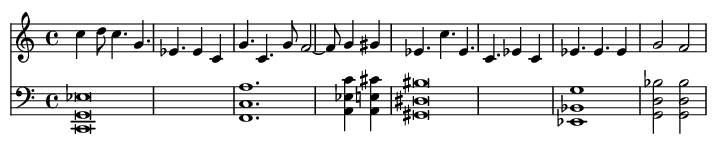

In [ ]:
# Display and play the random hook
show(my_score)
play(my_score, 126)